In [453]:
from scipy.io import wavfile
from scipy.signal.windows import kaiser
from scipy.signal import resample, resample_poly, convolve, correlate
import matplotlib.pyplot as plt
import numpy as np
import os

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "Computer Modern Serif",
        "font.size": 24,
        "text.latex.preamble": "\n".join([r"\usepackage{siunitx}"]),
    }
)

In [454]:
files = os.listdir("input")
files

['belgium.wav',
 'argentina.wav',
 'audio_137620000Hz_09-06-05_28-09-2023.wav',
 'slovenia.wav',
 'audio_137620000Hz_19-52-42_06-09-2023.wav',
 'audio_137100000Hz_20-59-12_04-09-2023.wav',
 'penguin.jpg',
 'penguinsound.wav',
 'eye.jpg',
 'duck.jpg',
 'duck.wav',
 'penguin.wav',
 'eye.wav']

In [455]:
file = files[3]
print(file)
rec_sr, data = wavfile.read(f'input/{file}')

if data.ndim > 1:
    data = data[:, 1]

print(data.shape)
sr = 20800
data = data.astype(float)
data = data - np.mean(data)


slovenia.wav
(15113277,)


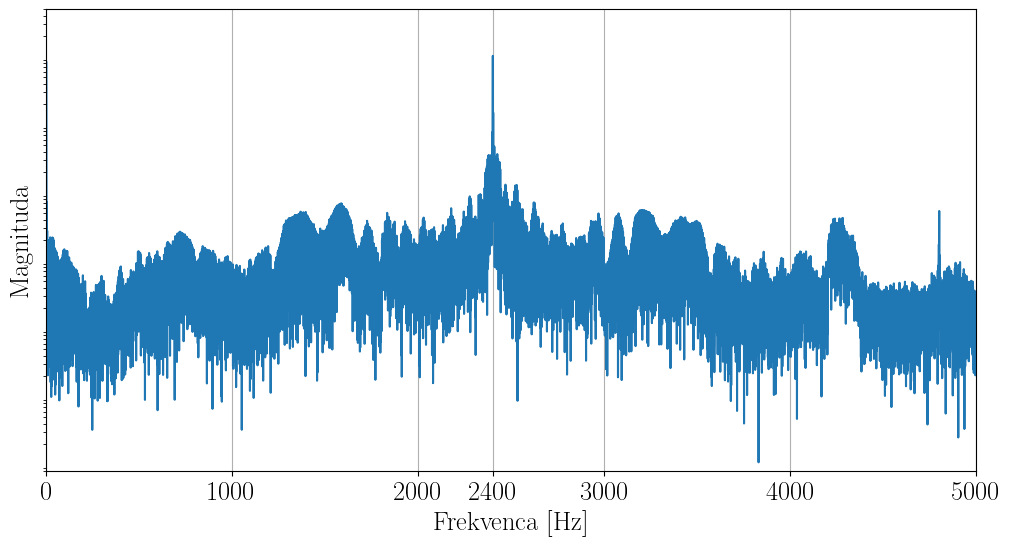

In [456]:
def fft_plot(data, sr):
    segment = data[30 * sr:35 * sr]

    fft = np.fft.rfft(segment)
    freqs = np.fft.rfftfreq(len(segment), 1 / sr)

    plt.figure(figsize=(12, 6))
    plt.semilogy(freqs, np.abs(fft))
    plt.xlim(0, 5000) 
    plt.xlabel("Frekvenca [Hz]")
    plt.ylabel("Magnituda")
    plt.grid(True)
    plt.yticks([])
    xticks = plt.xticks()[0]
    plt.xticks(list(xticks) + [2400])
    plt.ylim(8e2, 5e9)
    # plt.savefig("images/fft_plot.pdf")
    plt.show()


plt.rcParams.update({'font.size': 19})
fft_plot(data, rec_sr)

In [457]:
data.shape, rec_sr, data.shape[0] / rec_sr

((15113277,), 48000, 314.8599375)

In [458]:
def resample_decimate(data, sr, rec_sr):
    gcd = np.gcd(sr, rec_sr)
    L = sr // gcd
    M = rec_sr // gcd
    f_cutoff = 0.5 * np.min([1 / M, 1 / L])

    def sinc(n):
        return 2 * f_cutoff * np.sinc(2 * f_cutoff * n)
    
    n = 101
    ns = np.arange(-(n-1) / 2, (n+1) / 2)

    sinc_window = sinc(ns)
    kaiser_window = kaiser(n, beta=8.6)
    window = kaiser_window * sinc_window
    window = window / np.sum(window)

    y = np.zeros((len(data) * int(L))// M, dtype=np.float32)

    for n in range(y.shape[0]):
        y_n = 0
        for k in range(len(window)):
            h = window[k]
            m = (n * M - k)
            if (m / L).is_integer():
                x_m = data[m // L]
            else:
                x_m = 0 
            y_n += x_m * h
        y[n] = y_n


    return y


def resample_decimate(data, sr, rec_sr):
    gcd = np.gcd(sr, rec_sr)
    L = sr // gcd
    M = rec_sr // gcd
    return resample_poly(data, L, M, window=('kaiser', 8.6))



In [459]:

def demodulate(y, sr):
    demodulated = np.zeros(y.shape[0])

    f_carrier = 2400
    phi = 2 * np.pi * f_carrier / sr
    cosphi = np.cos(phi)
    sinphi_sq = np.sin(phi) ** 2
    previous = y[0]

    for i in range(1, y.shape[0]):
        current = y[i]
        # using square of amplitude to avoid sqrt
        demodulated[i] = np.sqrt((previous ** 2 + current ** 2 - (previous * current * 2 * cosphi)) / sinphi_sq)
        previous = current

    return demodulated


In [460]:
decimated = resample_decimate(data, sr, rec_sr)
# n_samples = int(len(data) * sr / rec_sr)
# decimated = resample(data, n_samples)

In [461]:
demodulated = demodulate(decimated, sr)
signal = resample_decimate(demodulated, 4160, sr)
# n_samples = int(len(data) * 4160 / sr)
# signal = resample(demodulated, n_samples)

In [462]:
sync_frame_str = "..WW..WW..WW..WW..WW..WW..WW........"
sync_frame = np.array([1 if x == "W" else -1 for x in sync_frame_str])
correlated = correlate(sync_frame, signal, mode="valid")


sync_frame_str0 = "000010001000100010001000100010000000000"
sync_frame_str1 = "000011100111001110011100111001110011100"
sync_frame = [int(x) * 2 - 1 for x in sync_frame_str0]
correlated = correlate(signal, sync_frame, mode="same")
diff_correlated = -np.diff(correlated)


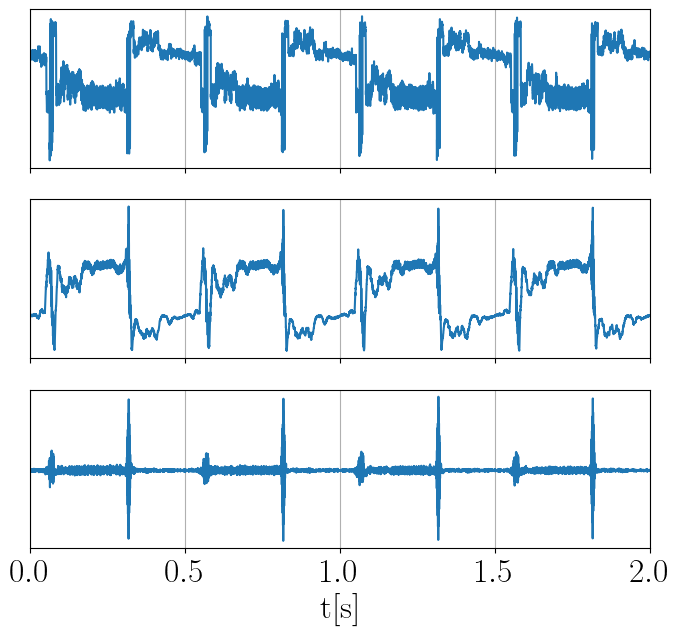

In [463]:
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 24})
t = 50
n = 4160
x = [i / 4160 for i in range(0, n * 2)]

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 7))

axs[0].plot(x, signal[(t-2) * n : t * n])
axs[1].plot(x, correlated[(t-2) * n : t * n])
axs[2].plot(x, diff_correlated[(t-2) * n : t * n])

for ax in axs:
    ax.set_yticks([])
    ax.grid()
    ax.set_xlim(0, 2)
plt.xlabel("t[s]")
# plt.savefig("images/belgium_corr.pdf")
plt.show()

In [464]:
inc = 2080
lines = []
for ind in range(0, len(signal), inc):
    start = np.argmax(diff_correlated[ind:ind + inc]) + ind - 39 // 2
    line = signal[start:start + inc]
    if len(line) < inc or start < 0: continue
    brightness = ((line - np.min(line)) / (np.max(line) - np.min(line)) * 255).astype(np.uint8)
    lines.append(brightness)

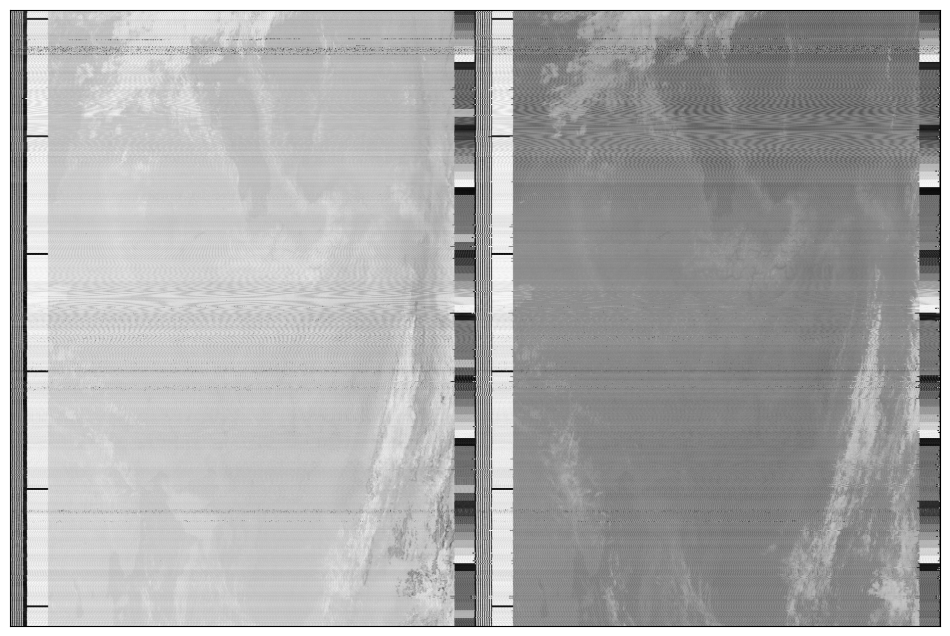

In [466]:
import matplotlib.pyplot as plt
import numpy as np

image = np.vstack(lines)
plt.figure(figsize=(12, 8))
plt.imshow(image, cmap='gray', aspect='auto')
plt.yticks([])
plt.xticks([])
plt.savefig("images/slovenia.pdf")
plt.show()